# Lecture 16 Notebook

CSCI 3022, Fall 2023

[Acknowledgments Page](https://ds100.org/sp23/acks/)

In [40]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
adjust_fontsize(size=20)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Plotting helper functions.

In [3]:
# Helper functions to plot and 
# Compute expectation, variance, standard deviation
def plot_dist(dist_df,
                      xname="x", pname="P(X = x)", varname="X",
                      save=False, mean=False):
    """
    Plot a distribution from a distribution table.
    Single-variate.
    """
    expected_value = sum(dist_df[xname]*dist_df[pname])
    plt.bar(dist_df[xname], dist_df[pname])
    plt.ylabel(pname)
    plt.xlabel(xname)
    plt.title(f"Distribution of ${varname}$")
    plt.xticks(sorted(dist_df[xname].unique()))
    if mean==True:
        plt.scatter(expected_value, -0.015, marker='^', color='red', s=100)
    if save:
        fig = plt.gcf()
        fig.patch.set_alpha(0.0)
        plt.savefig(f"dist{varname}.png", bbox_inches = 'tight');


def simulate_samples(df, xname="x", pname="P(X = x)", size=1):
    return np.random.choice(
                df[xname], # Draw from these choiecs
                size=size, # This many times
                p=df[pname]) # According to this distribution

def simulate_iid_df(dist_df, nvars, rows, varname="X"):
    """
    Make an (row x nvars) dataframe
    by calling simulate_samples for each of the nvars per row
    """
    sample_dict = {}
    for i in range(nvars):
        # Generate many datapoints 
        sample_dict[f"{varname}_{i+1}"] = \
            simulate_samples(dist_df, size=rows)
    return pd.DataFrame(sample_dict)


def plot_simulated_dist(df, colname, show_stats=True, save=False, **kwargs):
    """
    Plot a simulated population.
    """
    sns.histplot(data=df, x=colname, stat='probability', discrete=True, **kwargs)
    plt.xticks(sorted(df[colname].unique())) # if there are gaps)
    if show_stats:
        display(stats_df_multi(df, [colname]))
    if save:
        fig = plt.gcf()
        fig.patch.set_alpha(0.0)
        plt.savefig(f"sim{colname}.png", bbox_inches = 'tight');

def stats_df_multi(df, colnames):
    means = df[colnames].mean(axis=0)
    variances = df[colnames].var(axis=0)
    stdevs = df[colnames].std(axis=0)
    df_stats = pd.concat([means, variances, stdevs],axis=1).T
    df_stats['index_col'] = ["E[•]", "Var(•)", "SD(•)"]
    df_stats = df_stats.set_index('index_col', drop=True).rename_axis(None)
    return df_stats

def plot_simulated_dist_multi(df, colnames, show_stats=True):
    """
    If multiple columns provided, use separate plots.
    """
    ncols = 1
    nrows = len(colnames)
    plt.figure(figsize=(6, 2*nrows+2))
    
    for i, colname in enumerate(colnames):
        subplot_int = int(100*int(nrows) + 10*int(ncols) + int(i+1))
        plt.subplot(subplot_int)
        plot_simulated_dist(df, colname, show_stats=False)
    plt.tight_layout()
    if show_stats:
        display(stats_df_multi(df, colnames))

In [30]:
from scipy.stats import expon

In [50]:
#P(X>1) when X~exp(.002)
# 1- P(X<=1)  Note:  Scale = 1/lambda

1-expon.cdf(1, scale=1/.002)

0.9980019986673331

In [51]:
from scipy.stats import norm

In [60]:
#X~N(4, 2)
#1-P(X<=6)
1-norm.cdf(6, loc=4, scale=np.sqrt(2))

0.07864960352514261

In [57]:
from scipy.stats import poisson

In [58]:
#P(X=0)  given X~Pois(0.002)
poisson.pmf(0, .002)

0.9980019986673331

---

## A Random Variable: Roulette Example

Roulette:  Let X be your winnings if you bet $1 on any particular number and play once.



In [5]:
# Our random variable X
dist_df = pd.DataFrame({"x": [-1, 35],
                        "P(X = x)": [37/38, 1/38]})
dist_df

,x,P(X = x)
0,-1,0.973684
1,35,0.026316


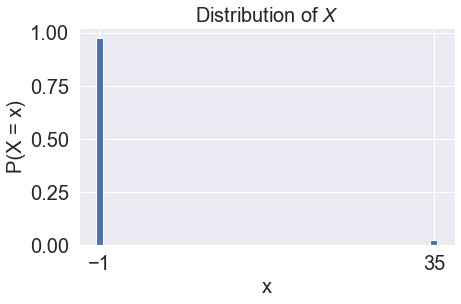

In [41]:
plot_dist(dist_df, save=True)

## Expected Value of X:

In [32]:
expected_value = (dist_df["x"]*dist_df["P(X = x)"]).sum()

expected_value


-0.052631578947368474

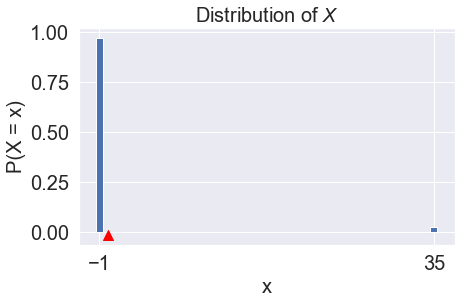

In [45]:
plot_dist(dist_df, save=True, mean=True)


## Variance and Standard Deviation of X:

In [31]:
var = ((dist_df["x"]-expected_value)**2*dist_df["P(X = x)"]).sum()

print ("Variance of X is ",var)

std = np.sqrt(var)

print ("Std deviation of X is ",std)

Variance of X is  33.20775623268698
Std deviation of X is  5.762617133966734


<br/><br/>

---

# Die Is the Singular; Dice Is the Plural

Let X be the outcome of a single die roll. X is a random variable.

In [31]:
# Our random variable X
roll_df = pd.DataFrame({"x": [1, 2, 3, 4, 5, 6],
                        "P(X = x)": np.ones(6)/6})
roll_df

,x,P(X = x)
0,1,0.166667
1,2,0.166667
2,3,0.166667
3,4,0.166667
4,5,0.166667
5,6,0.166667


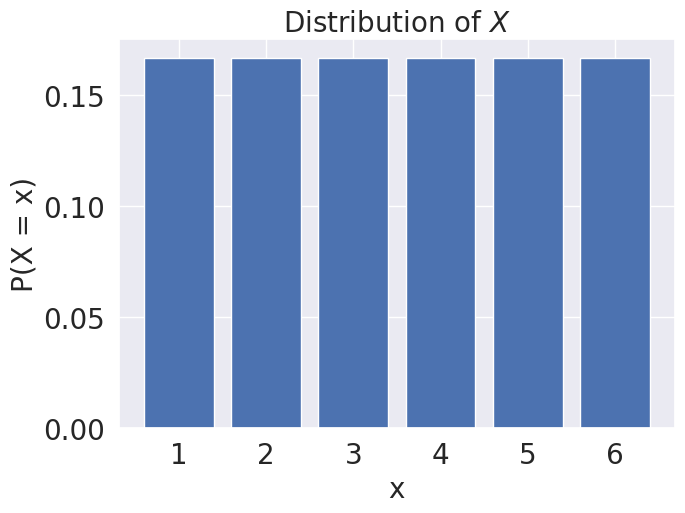

In [23]:
plot_dist(roll_df)

<br/><br/>

---

# Sum of 2 Dice Rolls

Here's the distribution of a single die roll:

In [32]:
roll_df = pd.DataFrame({"x": [1, 2, 3, 4, 5, 6],
                        "P(X = x)": np.ones(6)/6})
roll_df

,x,P(X = x)
0,1,0.166667
1,2,0.166667
2,3,0.166667
3,4,0.166667
4,5,0.166667
5,6,0.166667


Let $X_1, X_2$ are the outcomes of two dice rolls. Note $X_1$ and $X_2$ are i.i.d. (independent and identically distributed).

Below I call a helper function `simulate_iid_df`, which simulates an 80,000-row table of $X_1, X_2$ values. It uses `np.random.choice(arr, size, p)` [link](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) where `arr` is the array the values and `p` is the probability associated with choosing each value. If you're interested in the implementation details, scroll up.

In [33]:
N = 80000
sim_rolls_df = simulate_iid_df(roll_df, nvars=2, rows=N)
sim_rolls_df

,X_1,X_2
0,2,2
1,6,1
2,5,2
3,2,5
4,3,4
...,...,...
79995,2,5
79996,1,3
79997,2,1
79998,2,2


Define the following random variables, which are functions of $X_1$ and $X_2$:
* $Y = X_1 + X_1 = 2 X_1$
* $Z = X_1 + X_2$

We can use our simulated values of $X_1, X_2$ to create new columns $Y$ and $Z$:

In [34]:
sim_rolls_df['Y'] = 2 * sim_rolls_df['X_1']
sim_rolls_df['Z'] = sim_rolls_df['X_1'] + sim_rolls_df['X_2']
sim_rolls_df

,X_1,X_2,Y,Z
0,2,2,4,4
1,6,1,12,7
2,5,2,10,7
3,2,5,4,7
4,3,4,6,7
...,...,...,...,...
79995,2,5,4,7
79996,1,3,2,4
79997,2,1,4,3
79998,2,2,4,4


Now that we have simulated samples of $Y$ and $Z$, we can plot histograms to see their distributions!

<br/>
Distribution of $Y$, which was twice the value of our first die roll:

,Y
E[•],7.008800
Var(•),11.617668
SD(•),3.408470


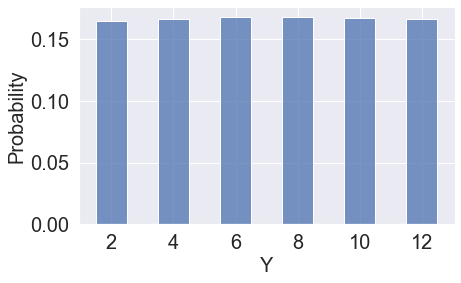

In [35]:
plot_simulated_dist(sim_rolls_df, "Y", save=True)

Distribution of $Z$, the sum of two IID dice rolls:

,Z
E[•],7.002763
Var(•),5.868828
SD(•),2.422566


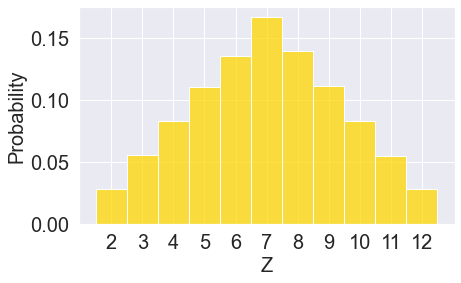

In [11]:
plot_simulated_dist(sim_rolls_df, "Z", save=True, color='gold')

Let's compare the expectations and variances of these simulated distributions of $Y$ and $Z$.
* We computed:
    * $\mathbb{E}[Y]$ as `np.mean(sim_rolls_df['Y'])`
    * $\text{Var}(Y)$ as `np.var(sim_rolls_df['Y']`
    * etc.
* The larger your simulated rows $N$, the closer the simulated expectation will be to the true expectation.
* Our approach is tedious--we have to simulate an entire population, then reduce it down to expectation/variance/standard deviation. It turns out we can calculate the Expected Value and Variance of linear sums of RV using properties of expected value and variance.  See the extra slides at the end of Lec 16 for details!

In [36]:
stats_df_multi(sim_rolls_df, ["Y", "Z"])

,Y,Z
E[•],7.008800,7.002700
Var(•),11.617668,5.807315
SD(•),3.408470,2.409837


In [37]:
(4/5)*(3/4)/((4/5)*(3/4)+(1/4)*(2/5))

0.8571428571428572

In [38]:
3/7

0.42857142857142855

In [39]:
6/7

0.8571428571428571